"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [127]:
import pymc3 as pm
import theano
import theano.tensor as tt
import numpy as np
import pylab as plt
from scipy.stats import poisson

In [2]:
def var_sig_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-b*x))

def var_sig_exp_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-np.exp(b)*x))


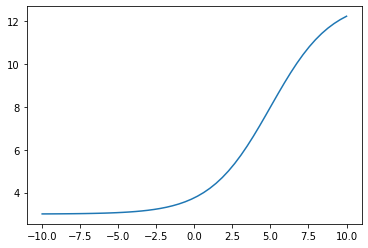

In [132]:
b = 0.5
inflect = 5
min_val = 3
scale = 10
x = np.linspace(-10,10)
y = min_val + var_sig_np(x-inflect,b)*scale
plt.plot(x,y)

In [110]:
def var_sig_exp_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-tt.exp(b)*x))

def var_sig_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-b*x))

idx = np.arange(len(y))

with pm.Model() as model:
    #sig_b = pm.Normal('sig_b', 5,10)
    sig_b = pm.HalfCauchy('sig_b', 1)
    
    tau_latent = pm.Beta('tau_latent', 2, 5, testval = 0.5)
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    min_val = pm.Normal('min_val', 0, 10)
    scale = pm.Normal('scale', 1, 10)
    
    lambda_ = pm.Deterministic('lambda_', min_val + var_sig_tt(idx-tau,sig_b)*scale)
    sigma = pm.HalfNormal('sigma',0.2)

    
    # Add observations
    observation = pm.Normal("obs", mu = lambda_, sigma = sigma, observed=y)

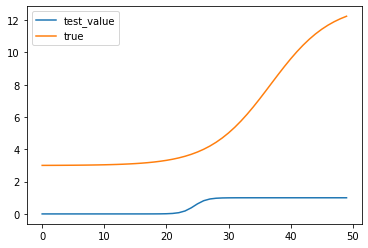

In [111]:
plt.plot(lambda_.tag.test_value,label='test_value')
plt.plot(y,label='true')
plt.legend()

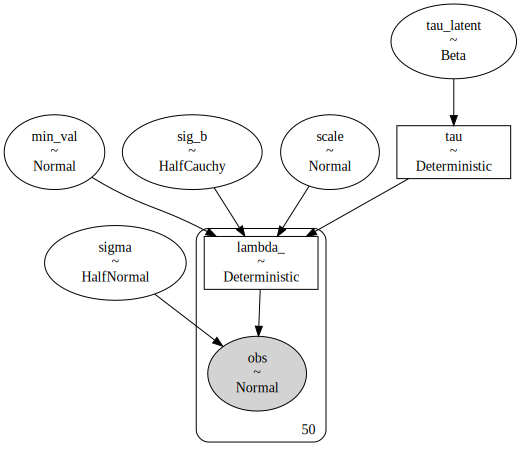

In [112]:
pm.model_to_graphviz(model)

In [113]:
with model:
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=0)

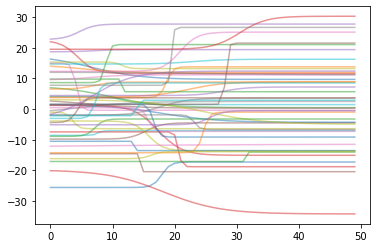

In [114]:
plt.plot(prior_checks['lambda_'].T, alpha = 0.5);

In [115]:
with model:
    inference = pm.ADVI('full-rank')
    tracker = pm.callbacks.Tracker(
            mean=inference.approx.mean.eval,  # callable that returns mean
            std=inference.approx.std.eval,  # callable that returns std
        )
    approx = pm.fit(n=40000, method=inference,
                   callbacks=[tracker])
    trace = approx.sample(draws=2000)

Finished [100%]: Average Loss = -29.261


In [116]:
def tracker_names_out(model):
    raw_rvs = model.free_RVs
    names = [x.name for x in raw_rvs]
    sizes = [x.tag.test_value.shape for x in raw_rvs]
    fin_sizes = [x[0] if x is not () else 1 for x in sizes]
    fin_names = [[this_name]*this_size for this_name, this_size in zip(names,fin_sizes)]
    fin_names = [x for y in fin_names for x in y]
    return fin_names

In [117]:
rv_names = tracker_names_out(model)
rv_names

['sig_b_log__', 'tau_latent_logodds__', 'min_val', 'scale', 'sigma_log__']

In [118]:
tracker_mean = np.stack(tracker['mean'])
tracker_std = np.stack(tracker['std'])

In [119]:
x = np.linspace(-3,3)
outs = np.stack([var_sig_exp_np(x,b) for b in np.exp(tracker_mean[:,0])])

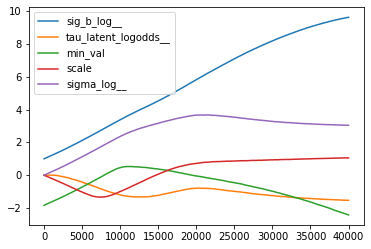

In [120]:
lineObjects = plt.plot(tracker_mean)
plt.legend(iter(lineObjects), rv_names)

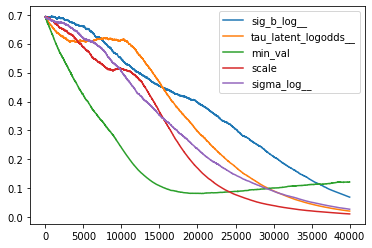

In [121]:
lineObjects = plt.plot(tracker_std)
plt.legend(iter(lineObjects), rv_names)

0.21694825997791606

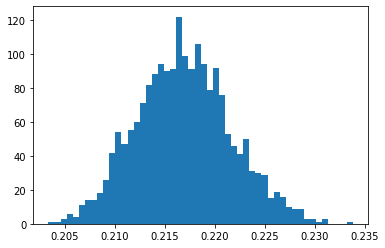

In [122]:
plt.hist(trace['sig_b'],50);
np.mean(trace['sig_b'])

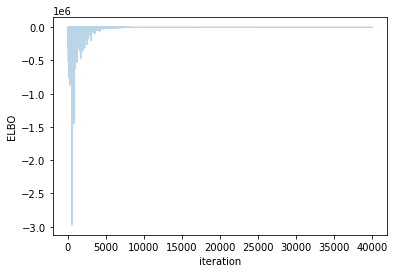

In [123]:
plt.plot(-approx.hist, alpha=.3)
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [124]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

In [125]:
tau = trace['tau']

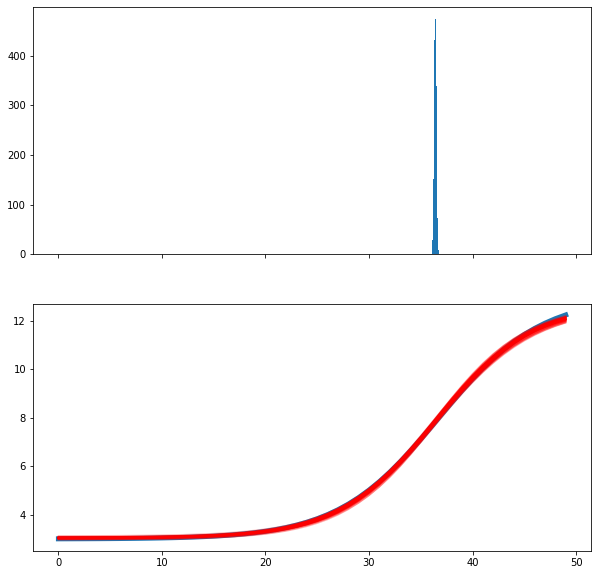

In [126]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].hist(tau)
ax[1].plot(y, linewidth = 5)
ax[1].plot(trace['lambda_'][:50].T,color='red', alpha = 0.3);
